In [1]:
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete
from collections import defaultdict
import time
import pickle
import os

In [2]:
CELL_SIZE = 100
MARGIN = 10

In [3]:
def get_coords(row, col, loc='center'):
    xc = (col+1.5) * CELL_SIZE
    yc = (row+1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE//2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = xc - half_size, xc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE//3
        x2, y2 = xc + CELL_SIZE//3, yc - CELL_SIZE//3
        x3, y3 = xc - CELL_SIZE//3, yc - CELL_SIZE//3
        return [(x1, y1), (x2, y2), (x3, y3)]

In [4]:
def draw_object(coords_list):
    if len(coords_list) == 1: # -> circle
        obj = rendering.make_circle(int(0.45*CELL_SIZE))
        obj_transform = rendering.Transform()
        obj.add_attr(obj_transform)
        obj_transform.set_translation(*coords_list[0])
        obj.set_color(0.2, 0.2, 0.2) # -> black
    elif len(coords_list) == 3: # -> triangle
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.9, 0.6, 0.2) # -> yellow
    elif len(coords_list) > 3: # -> polygon
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.4, 0.4, 0.8) # -> blue
    return obj

In [5]:
## Script: agent.py
from collections import defaultdict
import numpy as np
class Agent:
    def __init__(
            self, env,
            learning_rate=0.01,
            discount_factor=0.9,
            epsilon_greedy=0.9,
            epsilon_min=0.1,
            epsilon_decay=0.95):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        ## Define the q_table
        self.q_table = defaultdict(lambda: np.zeros(self.env.number_of_actions))
    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.env.number_of_actions)
        else:
            q_vals = self.q_table[state]
            perm_actions = np.random.permutation(self.env.number_of_actions)
            q_vals = [q_vals[a] for a in perm_actions]
            perm_q_argmax = np.argmax(q_vals)
            action = perm_actions[perm_q_argmax]
        return action
    def _learn(self, transition):
        s, a, r, next_s, done = transition
        q_val = self.q_table[s][a]
        if done:
            q_target = r
        else:
            q_target = r + self.gamma*np.max(self.q_table[next_s])
        ## Update the q_table
        self.q_table[s][a] += self.lr * (q_target - q_val)
        ## Adjust the epsilon
        self._adjust_epsilon()
    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [6]:
import numpy as np
import gymnasium
from gymnasium import spaces
from gymnasium.utils import seeding

class GridWorldEnv(gymnasium.Env):
    metadata = {'render.modes': ['human']} #  render env in human-readable mode. else output would look like for machine
    
    def __init__(self, num_rows=4, num_cols=6):
        super(GridWorldEnv, self).__init__()
        self.num_rows = num_rows
        self.num_cols = num_cols
        
        '''
        In environments where actions correspond to complex behaviors or where clarity is needed, defining actions explicitly is beneficial. 
        Makes the code more readable and understandable, especially when other developers or researchers are working 
        with or reviewing your environment. We want to do this for showing other data scientists examples
        '''
        self.action_defs = {
            0: lambda row, col: (max(row - 1, 0), col),  # up
            1: lambda row, col: (row, min(col + 1, self.num_cols - 1)),  # right
            2: lambda row, col: (min(row + 1, self.num_rows - 1), col),  # down
            3: lambda row, col: (row, max(col - 1, 0))  # left
        }
        
        self.number_of_actions = 4 
        #self.number_of_actions = len(self.action_defs)

        self.action_space = spaces.Discrete(4)  # 4 actions: up, right, down, left
        self.observation_space = spaces.Discrete(num_rows * num_cols)  # Total grid size

        self.grid2state_dict = {(r, c): r * num_cols + c for r in range(num_rows) for c in range(num_cols)}
        self.state2grid_dict = {v: k for k, v in self.grid2state_dict.items()}

        self.gold_cell = (num_rows // 2, num_cols - 2)
        self.trap_cells = [
            (self.gold_cell[0] + 1, self.gold_cell[1]), # below the gold
                           (self.gold_cell[0], self.gold_cell[1] - 1), # to the left of the gold
                           (self.gold_cell[0] - 1, self.gold_cell[1])
        ] # above the gold

        self.gold_state = self.grid2state_dict[self.gold_cell]
        self.trap_states = [self.grid2state_dict[cell] for cell in self.trap_cells]
        self.terminal_states = [self.gold_state] + self.trap_states

        self.state = 0  # Start at top-left corner

        self.seed()  # Seed for reproducibility

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def step(self, action): # this method, i control the agent actions manually, use this for testing
        assert self.action_space.contains(action), f"Invalid action: {action}"
        current_row, current_col = self.state2grid_dict[self.state]
        #print(f"Before action - State: {self.state}, Row: {current_row}, Col: {current_col}")

        move_func = self.action_defs[action]
        next_row, next_col = move_func(current_row, current_col)
        #print(f"Action: {['Up', 'Right', 'Down', 'Left'][action]} -> Next Row: {next_row}, Next Col: {next_col}")

        self.state = self.grid2state_dict[(next_row, next_col)]
        done = self.state in self.terminal_states
        reward = 1.0 if self.state == self.gold_state else -1.0 if self.state in self.trap_states else 0.0

       # print(f"After action - New State: {self.state}, Reward: {reward}, Done: {done}")
        return self.state, reward, done, {}
    
#     def step(self, action): # This method auto gets agent there 
#         assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
#         current_row, current_col = self.state2grid_dict[self.state]
#         print(f"Current state: {self.state} (Row: {current_row}, Col: {current_col})")  # Debugging output

#         move_func = self.action_defs[action]
#         next_row, next_col = move_func(current_row, current_col)
#         print(f"Action taken: {action} -> New position: (Row: {next_row}, Col: {next_col})")  # Debugging output

#         self.state = self.grid2state_dict[(next_row, next_col)]
#         done = self.state in self.terminal_states
#         reward = 1.0 if self.state == self.gold_state else -1.0 if self.state in self.trap_states else 0.0

#         print(f"New state: {self.state}, Reward: {reward}, Done: {done}")  # Debugging output
#         return self.state, reward, done, {}



    def reset(self):
        self.state = 0  # Reset to the top-left corner
        return self.state

    def render(self, mode='human'):
        grid = np.zeros((self.num_rows, self.num_cols), dtype=str)
        grid[:, :] = ' '
        row, col = self.state2grid_dict[self.state]
        grid[row, col] = 'A'  # Mark the agent's position
        grid[self.gold_cell[0], self.gold_cell[1]] = 'G'  # Mark the gold position
        for r, c in self.trap_cells:
            grid[r, c] = 'T'  # Mark trap positions

      #  print("\n".join(''.join(row) for row in grid))

    def close(self):
        pass




Episode 0: Reward -1.00 #Moves 9
Episode 1: Reward -1.00 #Moves 36
Episode 2: Reward -1.00 #Moves 34
Episode 3: Reward -1.00 #Moves 19
Episode 4: Reward -1.00 #Moves 20
Episode 5: Reward -1.00 #Moves 23
Episode 6: Reward -1.00 #Moves 38
Episode 7: Reward 1.00 #Moves 42
Episode 8: Reward -1.00 #Moves 160
Episode 9: Reward -1.00 #Moves 32
Episode 10: Reward -1.00 #Moves 141
Episode 11: Reward 1.00 #Moves 46
Episode 12: Reward 1.00 #Moves 313
Episode 13: Reward 1.00 #Moves 58
Episode 14: Reward 1.00 #Moves 282
Episode 15: Reward 1.00 #Moves 23
Episode 16: Reward 1.00 #Moves 26
Episode 17: Reward 1.00 #Moves 8
Episode 18: Reward 1.00 #Moves 10
Episode 19: Reward 1.00 #Moves 9
Episode 20: Reward 1.00 #Moves 8
Episode 21: Reward -1.00 #Moves 6
Episode 22: Reward 1.00 #Moves 11
Episode 23: Reward 1.00 #Moves 9
Episode 24: Reward 1.00 #Moves 8
Episode 25: Reward 1.00 #Moves 10
Episode 26: Reward 1.00 #Moves 8
Episode 27: Reward 1.00 #Moves 8
Episode 28: Reward 1.00 #Moves 8
Episode 29: Reward 

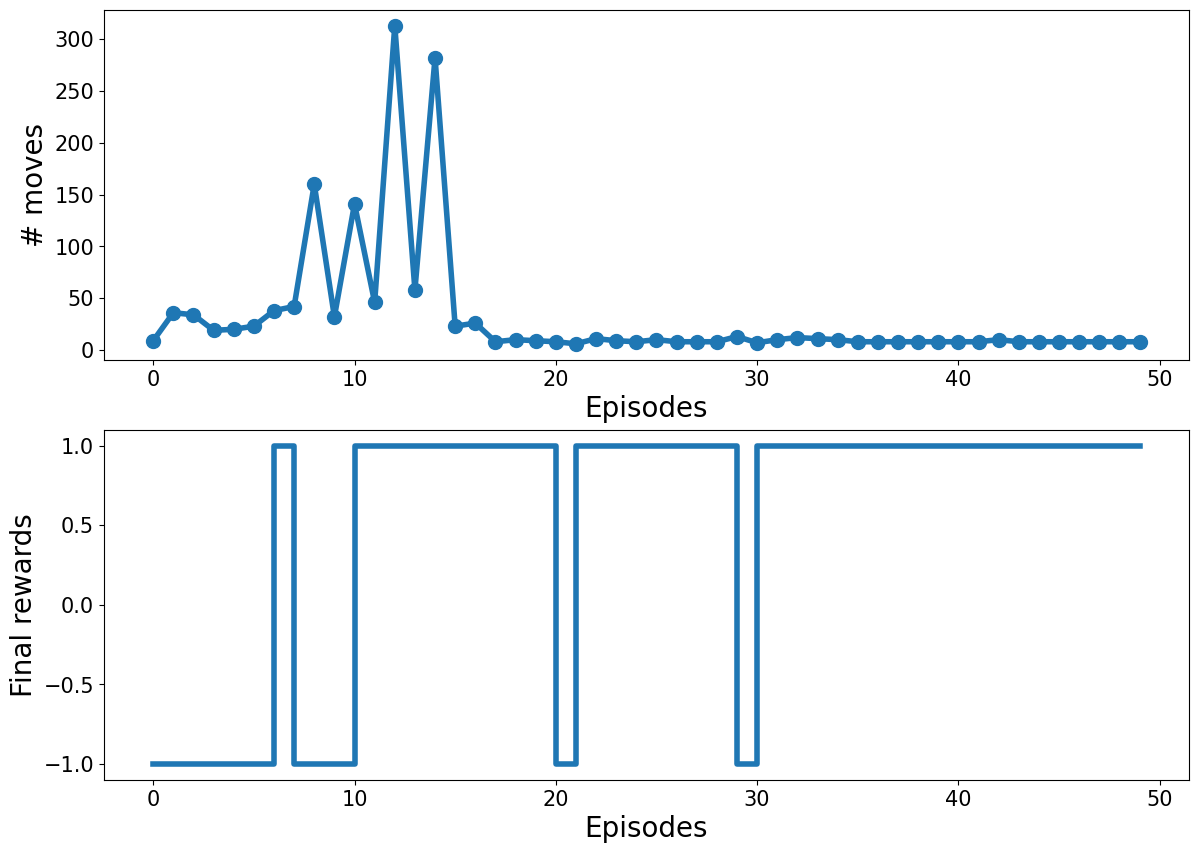

In [7]:
## Script: qlearning.py
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
Transition = namedtuple(
    'Transition', ('state', 'action', 'reward',
                   'next_state', 'done'))
def run_qlearning(agent, env, num_episodes=50):
    history = []
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment to starting state for each new episode
        env.render()  # Show initial state
        final_reward, n_moves = 0.0, 0  # Initialize counters for rewards and moves

        while True:
            action = agent.choose_action(state)  # Agent chooses an action based on current state
            next_state, reward, done, _ = env.step(action)  # Environment responds with next state and reward
            agent._learn(Transition(state, action, reward, next_state, done))  # Agent learns from the transition

            # Corrected debug print statement
         #   print(f"Learning: S={state}, A={action}, R={reward}, S'={next_state}, Done={done}")

            env.render()  # Render the state of the environment after the action
            state = next_state  # Update the state to the next state
            n_moves += 1  # Increment move counter
            final_reward = reward  # Update final reward received

            if done:
                break  # Exit the loop if the episode is done

        history.append((n_moves, final_reward))  # Record the number of moves and the final reward for the episode
        print(f'Episode {episode}: Reward {final_reward:.2f} #Moves {n_moves}')  # Print summary of the episode

    return history

def plot_learning_history(history):
    fig = plt.figure(1, figsize=(14, 10))
    ax = fig.add_subplot(2, 1, 1)
    episodes = np.arange(len(history))
    moves = np.array([h[0] for h in history])
    plt.plot(episodes, moves, lw=4,
             marker='o', markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('# moves', size=20)
    ax = fig.add_subplot(2, 1, 2)
    rewards = np.array([h[1] for h in history])
    plt.step(episodes, rewards, lw=4)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('Final rewards', size=20)
    plt.savefig('q-learning-history.png', dpi=300)
    plt.show()
if __name__ == '__main__':
    env = GridWorldEnv()
    agent = Agent(env)
    history = run_qlearning(agent, env)
    env.close()
    plot_learning_history(history)
